# Costa Rican Household Poverty Level Prediction

또 다른 Kaggle 도전에 오신 것을 환영합니다! 코스타리카 가계 빈곤 수준 예측 대회의 목적은 개인의 특성과 가정의 특성을 모두 활용하여 가정의 빈곤 수준을 예측할 수 있는 머신러닝 모델을 개발하는 것입니다. 이 "선행을 위한 데이터 과학" 프로젝트는 사람들이 광고를 클릭하게 하는 것보다 사회에 더 유익한 일에 우리의 기술을 투입할 수 있는 기회를 제공합니다!

이 노트에서는 전체 머신러닝 솔루션에 대해 살펴보겠습니다. 먼저 문제를 소개하고, 데이터셋에 대한 철저한 탐색 데이터 분석을 수행하고, 기능 엔지니어링을 수행하고, 여러 머신러닝 모델을 사용해 보고, 모델을 선택하고, 모델을 최적화하고, 마지막으로 모델의 출력을 검사하고, 그리십시오. 

## Problem and Data Explanation

문제 및 데이터 설명입니다.
이 대회의 데이터는 train.csv와 test.csv의 두 가지 파일로 제공됩니다. 교육 세트에는 9557개의 행과 143개의 열이 있는 반면 검정 세트에는 23856개의 행과 142개의 열이 있습니다. 각 행은 한 개인을 나타내며, 각 열은 개인 또는 개인의 가정에 대한 특징입니다. 교육 세트에는 1-4 척도로 빈곤 수준을 나타내며 경쟁사의 레이블인 목표라는 추가 열이 있습니다. 1의 값은 극빈입니다.

이것은 감독되는 다중 클래스 분류 기계 학습 문제입니다.

감독: 교육 데이터의 레이블과 함께 제공됩니다.
다중 클래스 분류: 레이블은 4개의 클래스가 있는 이산형 값입니다.
객관적으로
목적은 빈곤을 가구 단위로 예측하는 것입니다. 우리는 개개인의 고유한 특징을 가진 개인 수준에 대한 데이터를 제공받지만 그들의 가계에 대한 정보도 제공합니다. 작업에 대한 데이터 세트를 만들려면 각 가구의 개별 데이터를 일부 집계해야 합니다. 게다가, 우리는 시험 세트에 있는 모든 개인에 대해 예측을 해야 하는데, "가장만 채점에 사용된다"는 것은 우리가 가구 단위로 빈곤을 예측하기를 원한다는 것을 의미합니다.

중요 사항: 교육 데이터에서 모든 가구원의 라벨은 동일해야 하지만, 동일한 가구원의 라벨이 서로 다른 오류가 있습니다. 이 경우 각 가구의 가장에 대한 레이블을 사용하도록 지시받았으며, 이 레이블은 parentesco1 == 1.0인 행으로 식별할 수 있습니다. 이 문제를 해결하는 방법은 노트에서 다루겠습니다(자세한 내용은 경쟁업체의 주요 논의를 참조하십시오).

- 1 = extreme poverty 
- 2 = moderate poverty 
- 3 = vulnerable households 
- 4 = non vulnerable households



143개 열에 대한 설명은 경기 문서에서 확인할 수 있지만, 몇 가지 유의할 사항은 다음과 같습니다.

- ID : 각 개인에 대한 고유 식별자. 이 기능은 우리가 사용하는 기능이 아닙니다.
- idhogar : 각 가구의 고유 식별자입니다. 이 변수는 특징이 아니지만 한 가구의 모든 개인이 동일한 식별자를 갖게 되므로 가구별로 개인을 그룹화하는 데 사용됩니다.
- parentesco1 : 이 사람이 가장인지 여부를 나타냅니다.
- target : 한 가구의 모든 구성원에 대해 동일해야 하는 레이블입니다.

모델을 만들 때 각 가구당 가장의 빈곤수준을 표기한 라벨을 가지고 세대별로 교육할 것입니다. 원시 데이터에는 가구와 개인의 특성이 혼재되어 있는데 개별 데이터의 경우 가구별로 이를 집계할 수 있는 방법을 찾아야 할 것 같습니다. 개인들 중 일부는 가장이 없는 가정에 속해 있는데, 유감스럽게도 우리는 이 데이터를 훈련에 사용할 수 없습니다. 데이터와 관련된 이러한 문제는 실제 데이터에서 완전히 일반적인 문제이므로 데이터 과학 작업에서 발생할 데이터 세트를 준비하기에 적합합니다.

### Read in Data and Look at Summary Information


In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [2]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


즉, 정수 열이 130개, 부동(숫자) 열이 8개, 객체 열이 5개 있습니다. 정수 열은 불변 변수(0 또는 1을 차지하는) 또는 이산형 순서 값을 갖는 순서형 변수를 나타냅니다. 객체 열은 기계 학습 모델에 직접 입력될 수 없기 때문에 문제가 될 수 있습니다.

열차보다 행(개체)이 더 많은 검정 데이터를 살펴보겠습니다. 대상이 없기 때문에 열이 하나 적습니다!

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


### Integer Columns

Let's look at the distribution of unique values in the integer columns. For each column, we'll count the number of unique values and show the result in a bar plot.



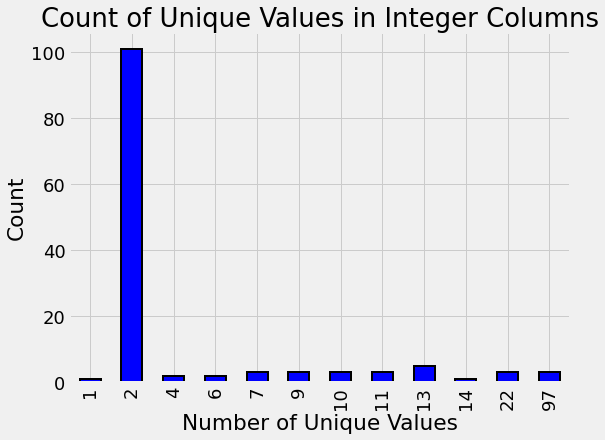

In [5]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');